<a href="https://colab.research.google.com/github/garnieroeliari/sporting_goods_retailer/blob/main/image_processing/notebook/sporting_goods_retailer_vanillacnn_300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sporting goods retailer - Multiclass Image Classification
##**Train and save a vanilla CNN model**

By Dina Garnier-Oeliarisoa


References : this notebook was adapted from [this tutorial](https://github.com/theairbend3r/how-to-train-your-neural-net/blob/master/pytorch/computer_vision/image_classification/04_multiclass_image_classification_pretrained_finetuned.ipynb). 

##**Import libraries**


In [1]:
# Libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import classification_report, confusion_matrix

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => /content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/


In [6]:
!ls '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/'

test  train


## Define transforms

Let's define a dictionary to hold the image transformations for train/test sets. All images are of size **(300,300)**. We will still resize (to prevent mistakes) all images to have size **(300, 300)** as well as convert the images to tensor. The `ToTensor` operation in PyTorch convert all tensors to lie between (0, 1). 

> `ToTensor` converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [7]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

## Initialize Datasets

### Train + Validation Dataset

We have 2 dataset folders with us - **Train** and **Test**. 

We will further divide our **Train** set as **Train + Val**. 

In [8]:
sporting_dataset = datasets.ImageFolder(root = root_dir + "train",
                                   transform = image_transforms["train"]
                                  )

sporting_dataset

Dataset ImageFolder
    Number of datapoints: 116
    Root location: /content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/train
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

### Class <=> ID Mapping of Output

The `class_to_idx` function is pre-built in PyTorch. It returns class ID's present in the dataset.

In [9]:
sporting_dataset.class_to_idx

{'decathlon': 0, 'gosport': 1, 'intersport': 2, 'sport2000': 3}

We will now construct a reverse of this dictionary; a mapping of ID to class. 

In [10]:
idx2class = {v: k for k, v in sporting_dataset.class_to_idx.items()}
idx2class

{0: 'decathlon', 1: 'gosport', 2: 'intersport', 3: 'sport2000'}

### Get Train and Validation Samples

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes. 

We could've also split our dataset into 2 parts - train and val ie. make 2 `Subsets`. But this is simpler because our data loader will pretty much handle everything now.



`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

Create a list of indices from 0 to length of dataset.

In [11]:
sporting_dataset_size = len(sporting_dataset)
sporting_dataset_indices = list(range(sporting_dataset_size))

Shuffle the list of indices using np.shuffle.

In [12]:
np.random.shuffle(sporting_dataset_indices)

Create the split index. We choose the split index to be 20% (0.2) of the dataset size.

In [13]:
val_split_index = int(np.floor(0.2 * sporting_dataset_size))

Slice the lists to obtain 2 lists of indices, one for train and other for test.

    0-----------val_split_index------------------------------n

Train => val_split_index to n

Val => 0 to val_split_index

In [14]:
train_idx, val_idx = sporting_dataset_indices[val_split_index:], sporting_dataset_indices[:val_split_index]

Finally, create samplers.

In [15]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

### Test

Now that we're done with train and val data, let's load our test dataset. 

In [16]:
sporting_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                        transform = image_transforms["test"]
                                       )

sporting_dataset_test

Dataset ImageFolder
    Number of datapoints: 8
    Root location: /content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

## Train, Validation, and Test Dataloader

Now, we will pass the samplers to our dataloader. Note that `shuffle=True` cannot be used when you're using the `SubsetRandomSampler`.

In [17]:
train_loader = DataLoader(dataset=sporting_dataset, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=sporting_dataset, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=sporting_dataset_test, shuffle=False, batch_size=1)

Let's look at a single image.

In [18]:
single_batch = next(iter(train_loader))

`single_batch` is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels. 

Here's the first element of the list which is a tensor. This tensor is of the shape `(batch, channels, height, width)`. 

In [19]:
single_batch[0].shape

torch.Size([8, 3, 300, 300])

Here are the output labels for the batch.

In [20]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([2, 1, 3, 3, 1, 3, 3, 1])

Output label tensor shape:  torch.Size([8])


To plot the image, we'll use `plt.imshow` from matloptlib. It expects the image dimension to be `(height, width, channels)`. We'll `.permute()` our single image tensor to plot it. 

In [21]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 300, 300])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


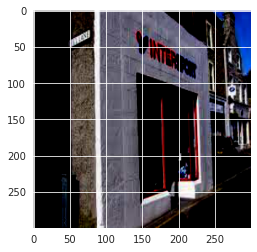

In [22]:
plt.imshow(single_image.permute(1, 2, 0))

PyTorch has made it easier for us to plot the images in a grid straight from the batch. 

We first extract out the image tensor from the list (returned by our dataloader) and set `nrow`. Then we use the `plt.imshow()` function to plot our grid. Remember to `.permute()` the tensor dimensions!

In [23]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


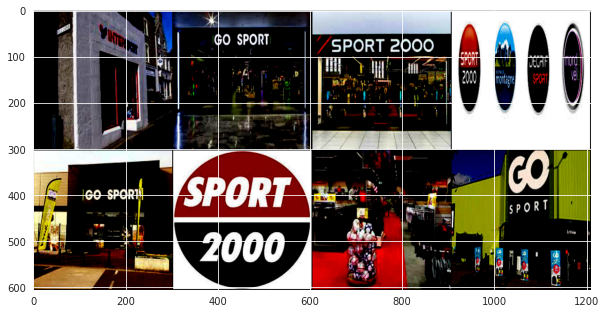

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Define a CNN Architecture

Our architecture is simple. We use 4 blocks of Conv layers. Each block consists of`Convolution` + `BatchNorm` + `ReLU` + `Dropout` layers.


We will not use an `FC` layer at the end. We'll stick with a `Conv` layer. 

#### Converting FC layers to CONV layers - [Source](https://cs231n.github.io/convolutional-networks/#convert)   

* It is worth noting that the only difference between `FC` and `CONV` layers is that the neurons in the `CONV` layer are connected only to a local region  in the input, and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it’s possible to convert between `FC` and `CONV` layers.
 
* For any `CONV` layer there is an `FC` layer that implements the same forward function. The weight matrix would be a large matrix that is mostly zero except for at certain blocks (due to local connectivity) where the weights in many of the blocks are equal (due to parameter sharing).

* Conversely, any `FC` layer can be converted to a `CONV` layer. For example, an `FC` layer with `K=4096` that is looking at some input volume of size `7×7×512` can be equivalently expressed as a `CONV` layer with `F=7,P=0,S=1,K=4096`.

* In other words, we are setting the filter size to be exactly the size of the input volume, and hence the output will simply be `1×1×4096` since only a single depth column “fits” across the input volume, giving identical result as the initial `FC` layer.

In [25]:
class SportingClassifier(nn.Module):
    def __init__(self):
        super(SportingClassifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=75, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block        

Now we'll initialize the model, optimizer, and loss function. 

Then we'll transfer the model to GPU. 

We're using the `nn.CrossEntropyLoss` even though it's a binary classification problem. This means, instead of returning a single output of `1/0`, we'll treat return 2 values of `0 and 1`. More specifically, probabilities of the output being either `1` or `0`.

We don't have to manually apply a `log_softmax` layer after our final layer because `nn.CrossEntropyLoss` does that for us.

However, we need to apply `log_softmax` for our validation and testing.

In [26]:
model = SportingClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

SportingClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 4, kernel_size=(75, 75), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


Before we start our training, let's define a function to calculate accuracy per epoch. 

This function takes `y_pred` and `y_test` as input arguments. We then apply softmax to `y_pred` and extract the class which has a higher probability.

After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [27]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

We'll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [28]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

Let's TRAIN our model!

You can see we've put a `model.train()` at the before the loop. `model.train()` tells PyTorch that you're in training mode. Well, why do we need to do that? If you're using layers such as `Dropout` or `BatchNorm` which behave differently during training and evaluation (for eample; not use `dropout` during evalualtion), you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don't explicitly have to write that. But it's good practice.

Similarly, we'll call `model.eval()` when we test our model. We'll see that below. Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we'll print out the loss/accuracy and reset it back to 0.

Then we have another for-loop. This for-loop is used to get our data in batches from the `train_loader`.

We do `optimizer.zero_grad()` before we make any predictions. Since the `.backward()` function accumulates gradients, we need to set it to 0 manually per mini-batch. From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform backpropagation using loss.backward() and optimizer.step().  


Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch. We add up all the losses/accuracies for each minibatch and finally divide it by the number of minibatches ie. length of `train_loader` to obtain the average loss/accuracy per epoch.

The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in `torch.no_grad` and not perform any backpropagation. `torch.no_grad()` tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

In [29]:
print("Begin training.")

for e in tqdm(range(1, 11)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
                
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 244.89461 | Val Loss: 361.12109 | Train Acc: 8.333| Val Acc: 0.000
Epoch 02: | Train Loss: 144.26998 | Val Loss: 61.78722 | Train Acc: 25.000| Val Acc: 100.000
Epoch 03: | Train Loss: 82.22713 | Val Loss: 22.82911 | Train Acc: 58.333| Val Acc: 0.000
Epoch 04: | Train Loss: 66.08612 | Val Loss: 74.76273 | Train Acc: 75.000| Val Acc: 0.000
Epoch 05: | Train Loss: 46.94888 | Val Loss: 129.16684 | Train Acc: 91.667| Val Acc: 100.000
Epoch 06: | Train Loss: 49.94391 | Val Loss: 5.64503 | Train Acc: 91.667| Val Acc: 100.000
Epoch 07: | Train Loss: 13.81114 | Val Loss: 13.05888 | Train Acc: 100.000| Val Acc: 100.000
Epoch 08: | Train Loss: 9.08455 | Val Loss: 0.00000 | Train Acc: 100.000| Val Acc: 100.000
Epoch 09: | Train Loss: 12.03993 | Val Loss: 0.00000 | Train Acc: 100.000| Val Acc: 100.000
Epoch 10: | Train Loss: 11.79367 | Val Loss: 0.00000 | Train Acc: 100.000| Val Acc: 100.000



## Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the `accuracy_stats` and `loss_stats` dictionaries.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

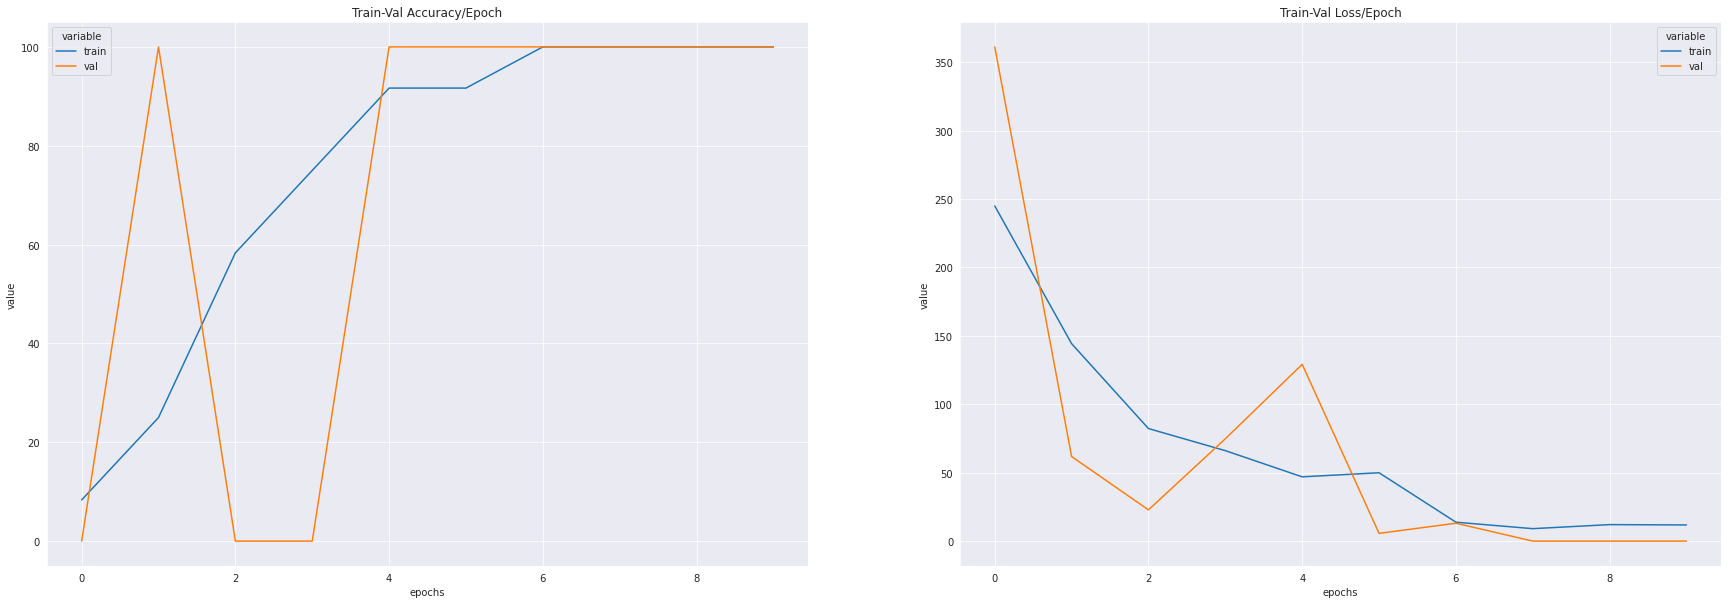

In [30]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test

After training is done, we need to test how our model fared. Note that we've used `model.eval()` before we run our testing code.
To tell PyTorch that we do not want to perform back-propagation during inference, we use `torch.no_grad()`, just like we did it for the validation loop above.

* We start by defining a list that will hold our predictions. Then we loop through our batches using the `test_loader`. For each batch -
* We move our input mini-batch to GPU.
* We make the predictions using our trained model.
* Apply log_softmax activation to the predictions and pick the index of highest probability.
* Move the batch to the GPU from the CPU.
* Convert the tensor to a numpy object and append it to our list.

In [31]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

We'll flatten out the list so that we can use it as an input to `confusion_matrix` and `classification_report`.

In [32]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

## Classification Report

Finally, we print out the classification report which contains the precision, recall, and the F1 score.

In [33]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.67      1.00      0.80         2
           3       0.33      0.50      0.40         2

    accuracy                           0.38         8
   macro avg       0.25      0.38      0.30         8
weighted avg       0.25      0.38      0.30         8



In [34]:
print(confusion_matrix(y_true_list, y_pred_list))

[[0 1 0 1]
 [0 0 1 1]
 [0 0 2 0]
 [1 0 0 1]]


## Confusion Matrix

We create a dataframe from the confusion matrix and plot it as a heatmap using the seaborn library.

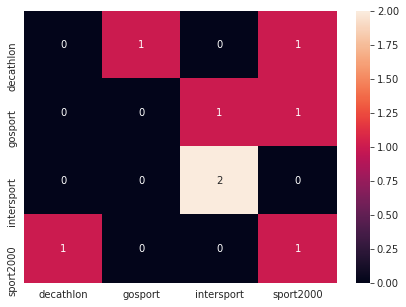

In [35]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [36]:
# SAVE MODEL
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/colab_image_processing/output/classif_sporting.pt')

In [37]:
# SAVE ENTIRE MODEL
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/colab_image_processing/output/all_classif_sporting.pt')